# Курсовая работа по предмету GeekBrain "Python для Data Science" 
### Тема: "Предсказание цены на недвижимость"
#### https://www.kaggle.com/eugenelel

**Импорт библиотек**

In [1]:
import numpy as np
import pandas as pd
import random
from scipy.stats import mode
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

**Пути к файлам**

In [2]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
SAMPLE_SUB__DATASET_PATH = './sample_submission.csv'

**Полезные функции**

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(30,30))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Data fields**<br>
* **Id** - идентификационный номер квартиры<br>
* **IDistrictId** - идентификационный номер района<br>
* **Rooms** - количество комнат<br>
* **Square** - площадь<br>
* **LifeSquare** - жилая площадь<br>
* **KitchenSquare** - площадь кухни<br>
* **Floor** - этаж<br>
* **HouseFloor** - количество этажей в доме<br>
* **HouseYear** - год постройки дома<br>
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности<br>
* **Social_1, Social_2, Social_3** - социальные показатели местности<br>
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья<br>
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров<br>
* **Price** - цена квартиры<br>

***Обработка исходных данных***

In [4]:
df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [5]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

***Анализ фич и целевой переменной***

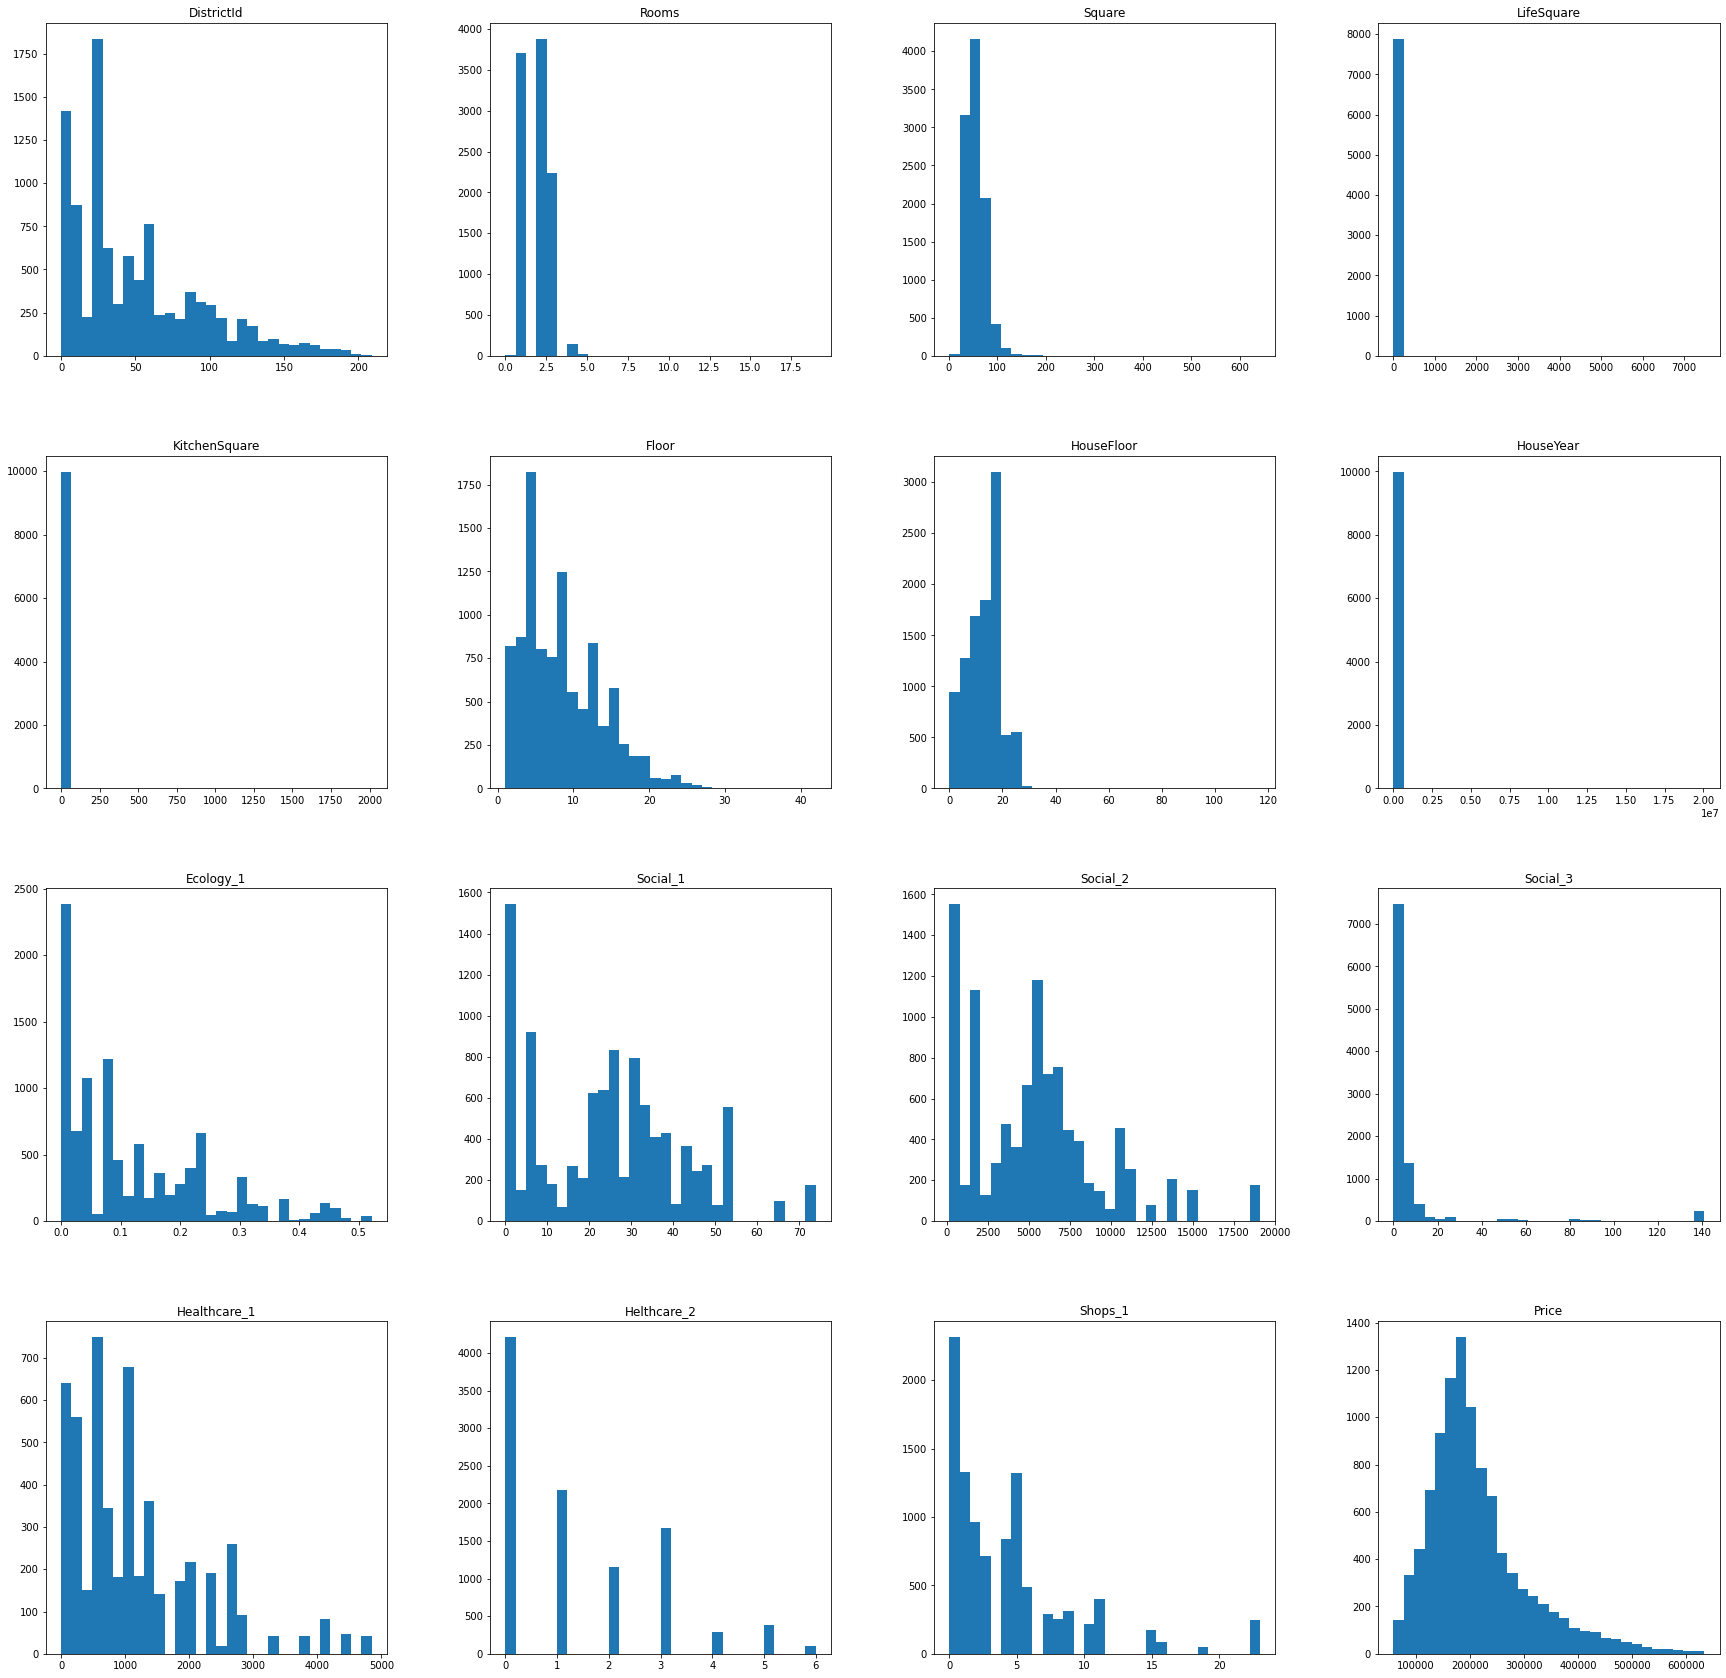

In [6]:
df_num_features = df.select_dtypes(include=['float64', 'int32', 'int64'])
df_num_features.drop('Id', axis=1, inplace=True)
## ID анализировать не будем
df_num_features.hist(figsize=(30,30), bins=30, grid=False);

по каждой фиче смотрим .value_counts() - ищем выбросы, ищем категориальные признаки<br>
**Видим, что есть явно категорийные переменные, с очевидными выбросами:**<br>
IDistrictId - идентификационный номер района<br>
Rooms - количество комнат<br>
Floor - этаж<br>
HouseFloor - количество этажей в доме<br>
**И переменные, похожие на категорийные:**<br>
Ecology_1 - экологические показатели местности<br>
Social_1, Social_2, Social_3 - социальные показатели местности<br>
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья<br>
Shops_1 - показатели, связанные с наличием магазинов, торговых центров<br>

# Обработка выбросов и пустых значений

**Убираем выбросы - Rooms**

In [7]:
# смотрим value_counts для Rooms, видим что есть квартиры с нулевым количеством комант и немного квартир с 5+ 
# количесвтом комнат считаем их выбросами

In [8]:
df.loc[df['Rooms'] == 0, 'Rooms'] = 1
df.loc[df['Rooms'] >= 6, 'Rooms'] = df['Rooms'].median()
df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**Убираем выбросы - KitchenSquare**

In [9]:
# смотрим value_counts для KitchenSquare - видим что есть много кухонь с площадью 1 кв метр, 
# а также кухни с площадь менее 5 метров и очень большие кухни

In [10]:
df[(df['KitchenSquare'] == 1) & (df['Rooms'] == 1) & (df['HouseYear'] > 1995)]
# предположим, что кухня с единичной площадью - это кухня в квартире-студии, тогда 
# количествто комнат должно быть ==1 и год постройки после 1995, в советское время студий, кажется не строили...
# для этого случая - оставляем площадь кухни - 1 м2, для остальных случаев, если кухня менее 5 метров, заменяем на 5.
# большие площади и отсутствующие значения приравниваем к 0,975 квантилю

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777
20,8768,63,1.0,50.974891,NaN,1.0,7,16.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,260328.413376
31,13084,38,1.0,47.837630,22.297739,1.0,21,24.0,2014,0.060753,B,B,15,2787,2,520.0,0,7,B,233717.298709
61,2556,23,1.0,43.043512,NaN,1.0,8,25.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,124902.555787
227,3746,62,1.0,46.722042,1.944446,1.0,11,12.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,133721.121715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9873,15219,23,1.0,34.632986,36.129394,1.0,4,3.0,2015,0.034656,B,B,0,168,0,NaN,0,0,B,87806.957199
9912,13523,23,1.0,52.787090,5.600609,1.0,7,1.0,2015,0.014073,B,B,2,475,0,NaN,0,0,B,104160.492175
9942,8256,58,1.0,41.806066,40.202217,1.0,1,4.0,2015,0.437885,B,B,23,5735,3,1084.0,0,5,B,94194.141120
9947,8062,6,1.0,41.606714,42.249308,1.0,20,25.0,2017,0.243205,B,B,5,1564,0,540.0,0,0,B,137389.035128


In [11]:
for i in range(len(df.index)):
    if df.loc[i,'KitchenSquare'] < 5:
        if df.loc[i,'Rooms'] == 1 and df.loc[i,'HouseYear'] > 1995: df.loc[i,'KitchenSquare'] = 1
        else: df.loc[i,'KitchenSquare'] = 5 
# для квартир-студий задаем площадь кухни = 1 (понимаю что for - это "костыль" - потом переделаю)

In [12]:
condition = (df['KitchenSquare'].isna()) \
             | (df['KitchenSquare'] > df['KitchenSquare'].quantile(.975))
df.loc[condition, 'KitchenSquare'] = df['KitchenSquare'].median()

In [13]:
df['KitchenSquare'].value_counts()

5.0     4004
8.0     1306
6.0     1227
10.0    1075
9.0      843
7.0      609
1.0      387
12.0     249
11.0     233
13.0      67
Name: KitchenSquare, dtype: int64

**Убираем выбросы - HouseFloor, Floor**

In [14]:
# Смотрим .value_counts() для HouseFloor и Floor, видим что есть дома с нулевой этажностью и очень большой этажностью
# а также этаж некоторых квартир больше этажности дома. 

In [15]:
df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()
df.loc[df['HouseFloor'] > 30, 'HouseFloor'] = df['HouseFloor'].median()
# заменяем дома с нулевой этажностью и этажностью большк 30 на медианную

In [16]:
condition = df.loc[df['Floor'] > df['HouseFloor']].index
df.loc[condition, 'Floor'] = df.loc[condition, 'HouseFloor'].apply(lambda x: random.randint(1, x))
# для квартир, этаж которых больше этажа дома - заменяем этаж на случайную величину между 1 этажом и этажом дома

In [17]:
# проверяем - остались ли квартиры, этаж которых больще чем этаж дома
(df['Floor'] > df['HouseFloor']).sum()

0

**Убираем выбросы - HouseYear**

In [18]:
# заменяем года постройки, которые больше текущего года - текущим годом

now = datetime.now().year
df.loc[df['HouseYear'] > now, 'HouseYear'] = now
df['HouseYear'].sort_values(ascending=False)

8828    2021
9163    2021
7721    2020
9122    2020
7955    2020
        ... 
7610    1916
6250    1914
2066    1912
2795    1912
6794    1910
Name: HouseYear, Length: 10000, dtype: int64

**Убираем пропуски LifeSquare**

In [19]:
# попробуем рассчитать ее как разницу между общей площадью и площадью кухни (для квартир у котрых есть данные по
# общей площади и площади кухни), умноженной на "коэфициент коридора" - 0,8

condition = (df['LifeSquare'].isna()) & (~df['Square'].isna()) & (~df['KitchenSquare'].isna())
df.loc[condition, 'LifeSquare'] = (df.loc[condition, 'Square'] - df.loc[condition, 'KitchenSquare'])*0.8
df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,84.021849,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,28.327926,5.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,5.0
9,79.867477,75.085125,5.0


**Убираем пропуски Healthcare_1**

In [20]:
df['Helthcare_2'].value_counts()
# Признак Helthcare_2 - категорийный, можно восстанавлиавать признак 'Healthcare_1' 
# приравнивая его к моде для соответсвующего призака Helthcare_2 

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

In [21]:
df[(df['Helthcare_2'] == 0) & (~df['Healthcare_1'].isna())]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272
9,8094,6,3.0,79.867477,75.085125,5.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945
10,535,2,3.0,74.199049,44.735889,10.0,5,14.0,2008,0.035145,B,B,42,9292,3,2620.0,0,3,B,512797.373401
25,4521,6,2.0,65.409965,48.327972,5.0,1,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608
31,13084,38,1.0,47.837630,22.297739,1.0,21,24.0,2014,0.060753,B,B,15,2787,2,520.0,0,7,B,233717.298709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9970,13501,6,1.0,41.310416,19.117077,9.0,1,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,114878.830713
9975,4944,6,2.0,52.573133,38.058506,5.0,4,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031184
9979,2201,6,1.0,40.043234,41.984322,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.083598
9989,729,58,2.0,45.118604,33.759011,5.0,8,12.0,1968,0.050756,B,B,24,5469,1,145.0,0,1,B,227361.501595


In [22]:
# df.loc[(df['Healthcare_1'].isna() & ~df['Helthcare_2'].isna()), 'Healthcare_1'] = df.loc[(df['Helthcare_2'])].mode()

In [23]:
# пока берем решение из базового проекта
df.drop('Healthcare_1', axis=1, inplace=True)

**Класс для подготовки исходных данных:**

In [24]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 2), 'Rooms_outlier'] = 1
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 2, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
             
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 5, 'KitchenSquare'] = 5
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] > 50, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
#         Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)

    
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        X.loc[condition, 'LifeSquare'] = (X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'])*0.77
        
        X.fillna(self.medians, inplace=True)
        
        return X

# Создание новых признаков

**Убираем строковые данные с помощью бинарных (дамми) переменных:**

In [25]:
# df = pd.concat([df, pd.get_dummies(df['Ecology_2'])], axis=1) 
# df.rename(columns = {'A':'Ecology_2_A', 'B':'Ecology_2_B'}, inplace = True) 
# df = pd.concat([df, pd.get_dummies(df['Ecology_3'])], axis=1) 
# df.rename(columns = {'A':'Ecology_3_A', 'B':'Ecology_3_B'}, inplace = True) 
# df = pd.concat([df, pd.get_dummies(df['Shops_2'])], axis=1) 
# df.rename(columns = {'A':'Shops_2_A', 'B':'Shops_2_B'}, inplace = True) 
# df = df.drop(columns = ['Ecology_2', 'Ecology_3', 'Shops_2'], axis = 1) 
# df = df.reindex(columns=['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_A', 'Shops_2_B', 'Price']) df.head()

In [26]:
binary_to_numbers = {'A': 0, 'B': 1}

df['Ecology_2'] = df['Ecology_2'].replace(binary_to_numbers)
df['Ecology_3'] = df['Ecology_3'].replace(binary_to_numbers)
df['Shops_2'] = df['Shops_2'].replace(binary_to_numbers)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int64  
 11  Ecology_3      10000 non-null  int64  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  int64  
 18  Price  

**признаки DistrictSize, IsDistrictLarge**

In [28]:
district_size = df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

In [29]:
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [30]:
df = df.merge(district_size, on='DistrictId', how='left')

In [31]:
df['IsDistrictLarge'] = (df['DistrictSize'] > 100).astype(int)

**признак MedPriceByDistrict**

In [32]:
med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

In [33]:
df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

**Класс для генерации признаков:**

In [34]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
   
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)

        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 7, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1945, 1970, 1980, 2000, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

**Отбор признаков**

In [35]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict']

In [36]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']


target_name = 'Price'

**Разделение на train и test**

In [37]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [39]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)

X_train.shape, X_valid.shape

((6700, 22), (3300, 22))

In [40]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)

X_train.shape, X_valid.shape

((6700, 29), (3300, 29))

In [41]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]


**Проверка на пустые значения**

In [42]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum()

(0, 0)

## Построение модели

**Обучение**

In [50]:
rf_model = RandomForestRegressor(n_estimators=120, min_samples_leaf=3, random_state=25, criterion='mse', max_depth = 24)

In [44]:
# params={
#         'min_samples_leaf':[3,4,5],
#         'n_estimators':[105,120,135],
#         'max_depth':[23,24,25]
#         }
# regr=GridSearchCV(RandomForestRegressor(),param_grid=params, scoring='r2', cv=5)
# regr.best_params_

# GridSearchCV(cv=5, estimator=RandomForestRegressor(),
#              param_grid={'max_depth': [23, 24, 25],
#                          'min_samples_leaf': [3, 4, 5],
#                          'n_estimators': [105, 120, 135]},
#              scoring='r2')
# {'max_depth': 24, 'min_samples_leaf': 3, 'n_estimators': 120}

In [52]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=24, min_samples_leaf=3, n_estimators=120,
                      random_state=25)

**Оценка модели**

Train R2:	0.913
Test R2:	0.722


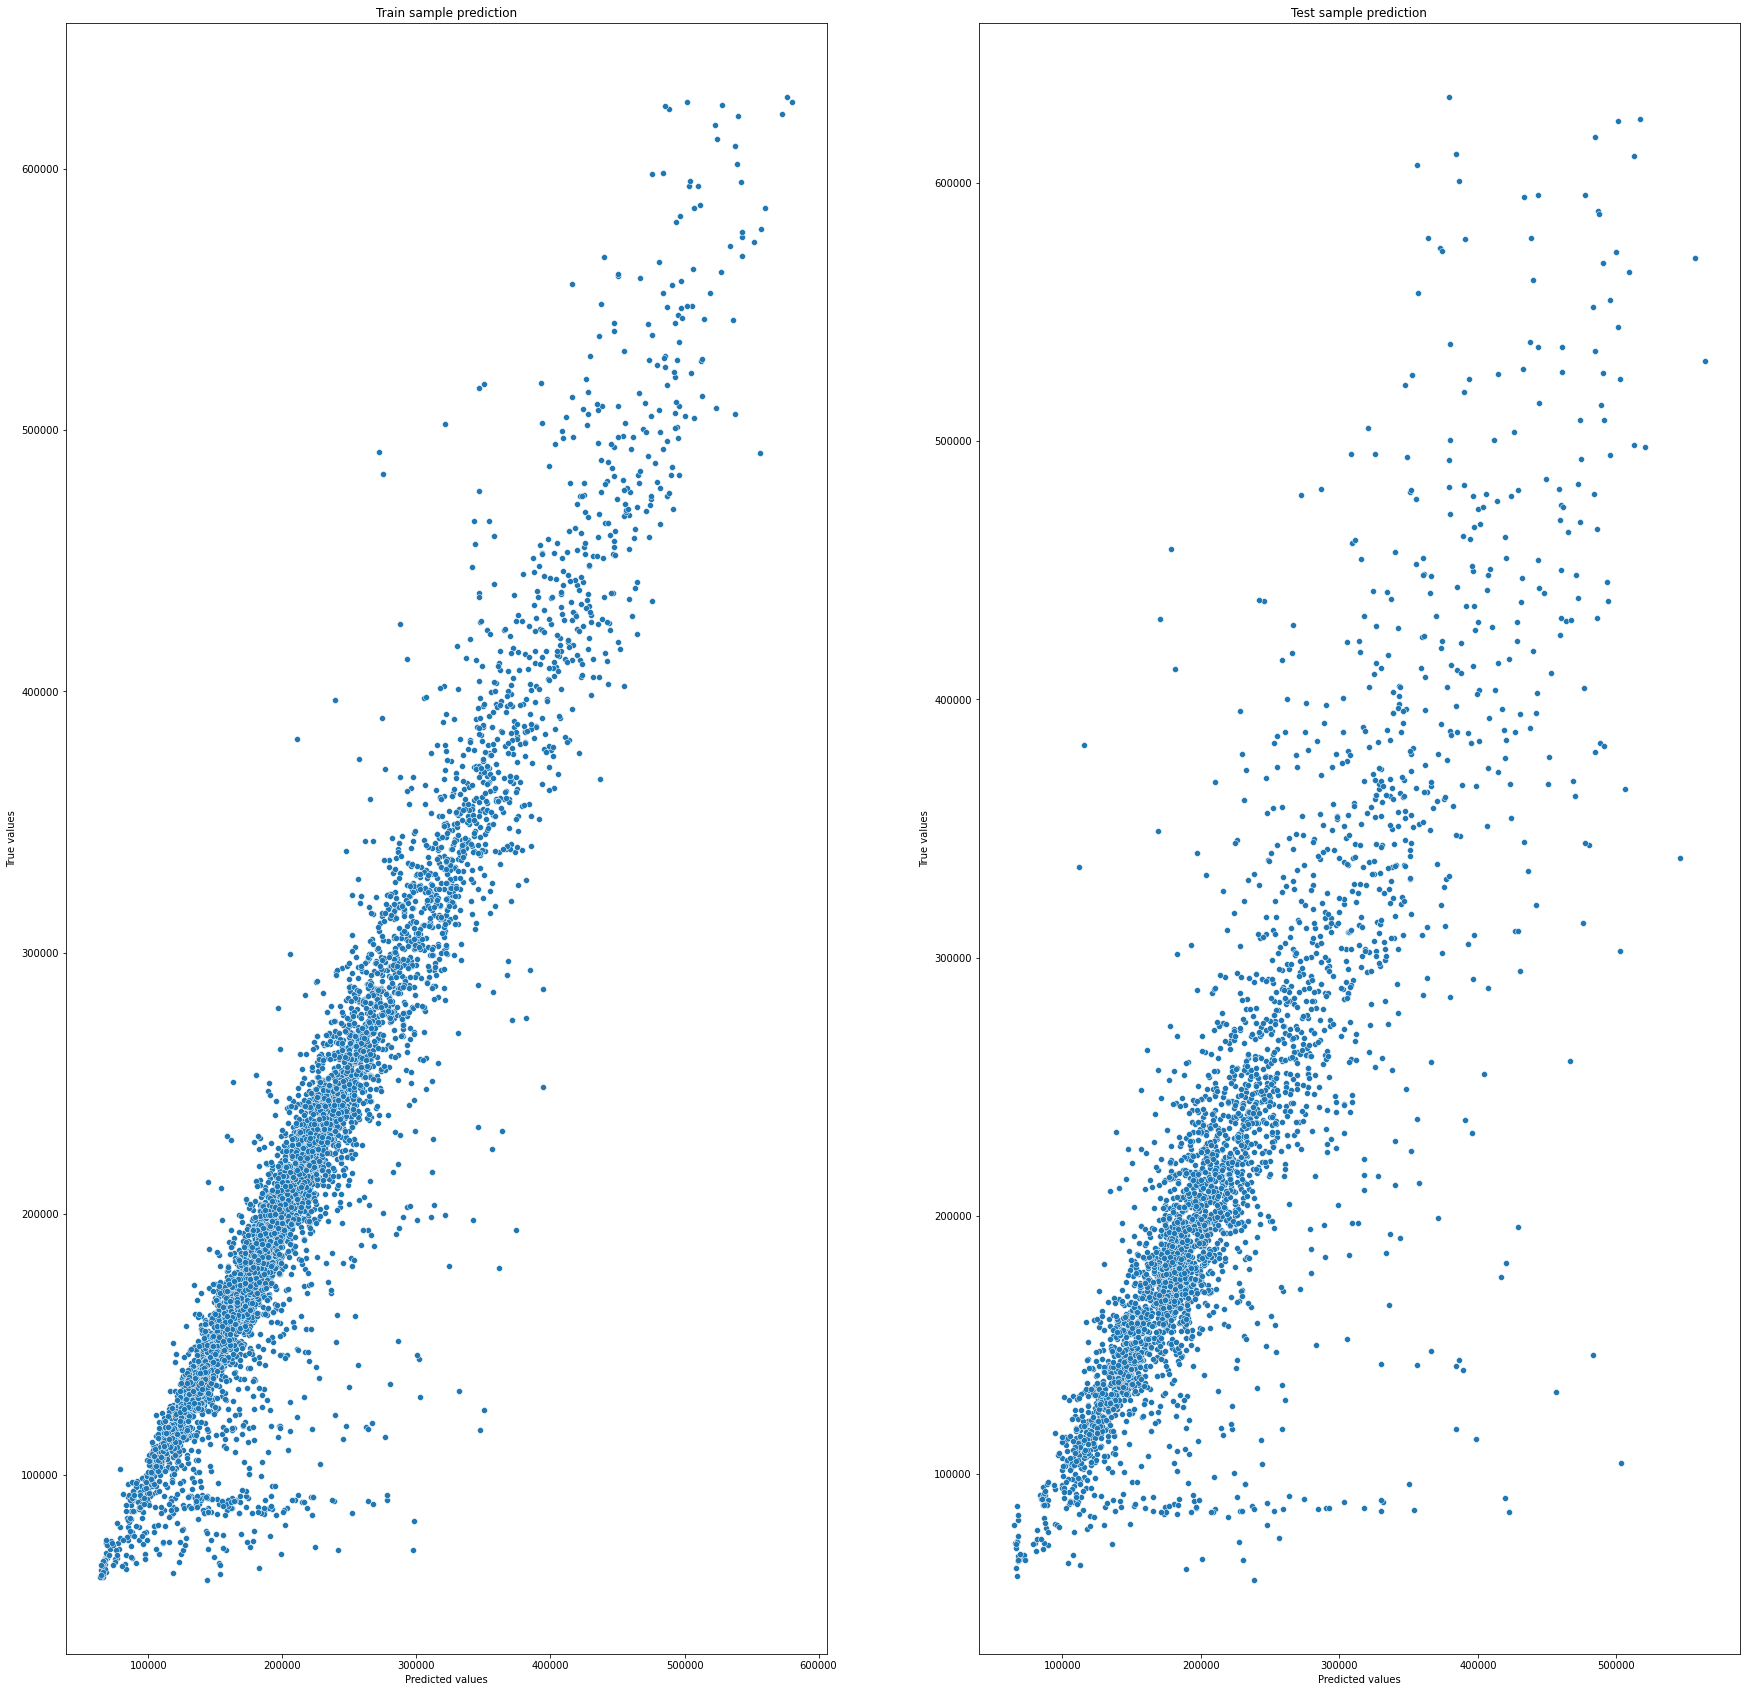

In [53]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс валидация**

In [54]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
print(cv_score)
print(cv_score.mean())

[0.74859101 0.6930797  0.73874886]
0.7268065222703267


**Важность признаков**

In [55]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
23,MedPriceByDistrict,0.519556
1,Square,0.266239
2,LifeSquare,0.026724
12,Social_3,0.025024
6,HouseYear,0.022924
10,Social_1,0.018698
5,HouseFloor,0.016623
11,Social_2,0.016108
4,Floor,0.015409
20,DistrictSize,0.015009


**Прогнозирование на тестовом датасете**

In [56]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df = preprocessor.transform(test_df)

In [57]:
test_df = features_gen.transform(test_df)
test_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,0,0,0,76.0,0,0,1.0,1,171145.169069,199170.067677
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,0,0,0,164.0,0,1,1.0,4,131107.271962,193208.613015
2,960,27,2.0,59.463678,38.857032,9.0,19,19.0,1977,0.211401,...,0,0,1,580.0,0,1,3.0,2,174924.307560,173934.865013
3,3848,23,2.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,0,0,0,372.0,0,1,0.0,1,150563.980606,183301.604459
4,746,74,1.0,53.837056,37.604533,5.0,8,17.0,1977,0.309479,...,0,0,1,65.0,0,0,2.0,2,164116.183543,182259.157907


In [58]:
test_df = test_df[feature_names + new_feature_names]
test_df.isna().sum().sum()

0

In [59]:
predictions = rf_model.predict(test_df)
predictions

array([153330.23647799, 121068.20142454, 159558.1866465 , ...,
       147833.77816069, 189125.76111778, 282306.41536108])

In [60]:
submit = pd.read_csv(SAMPLE_SUB__DATASET_PATH)

In [61]:
submit['Price'] = predictions

In [62]:
submit.to_csv('submits.csv', index=False)